In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import networkx as nx

from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline

In [3]:
seed = 3

# Load the data

In [4]:
# Kaggle data
path = 'data/tmdb-5000-movie-dataset/'
credits = pd.read_csv(path + 'tmdb_5000_credits.csv')
movies = pd.read_csv(path + 'tmdb_5000_movies.csv')

credits = credits.rename(columns={'movie_id': 'id'})

# merge the two data set credit and movies
movies = movies.merge(credits, how='inner', on='id')

movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."


# Clean and prepare the data

In [5]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'title_y', 'cast', 'crew'],
      dtype='object')

In [6]:
movies['earnings'] = (movies['revenue'] - movies['budget']) / movies['budget']

In [7]:
# keep only useful movies
movies = movies[['original_title', 'budget', 'revenue', 'earnings', 'production_companies', 'cast', 'crew']]
movies.head(100)

,original_title,budget,revenue,earnings,production_companies,cast,crew
0,Avatar,237000000,2787965087,10.763566,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,Pirates of the Caribbean: At World's End,300000000,961000000,2.203333,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,Spectre,245000000,880674609,2.594590,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,The Dark Knight Rises,250000000,1084939099,3.339756,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,John Carter,260000000,284139100,0.092843,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
5,Spider-Man 3,258000000,890871626,2.452991,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de..."
6,Tangled,260000000,591794936,1.276134,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""cast_id"": 34, ""character"": ""Flynn Rider (vo...","[{""credit_id"": ""52fe46db9251416c91062101"", ""de..."
7,Avengers: Age of Ultron,280000000,1405403694,4.019299,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...","[{""cast_id"": 76, ""character"": ""Tony Stark / Ir...","[{""credit_id"": ""55d5f7d4c3a3683e7e0016eb"", ""de..."
8,Harry Potter and the Half-Blood Prince,250000000,933959197,2.735837,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name""...","[{""cast_id"": 3, ""character"": ""Harry Potter"", ""...","[{""credit_id"": ""52fe4273c3a36847f801fab1"", ""de..."
9,Batman v Superman: Dawn of Justice,250000000,873260194,2.493041,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""A...","[{""cast_id"": 18, ""character"": ""Bruce Wayne / B...","[{""credit_id"": ""553bf23692514135c8002886"", ""de..."


In [8]:
# keep only movies that have non zero budgets and revenue
movies = movies[movies['budget'] != 0].reset_index(drop=True)
movies = movies[movies['revenue'] != 0].reset_index(drop=True)

In [9]:
movies.sort_values(by='earnings').head()
movies.head(100)

,original_title,budget,revenue,earnings,production_companies,cast,crew
0,Avatar,237000000,2787965087,10.763566,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,Pirates of the Caribbean: At World's End,300000000,961000000,2.203333,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,Spectre,245000000,880674609,2.594590,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,The Dark Knight Rises,250000000,1084939099,3.339756,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,John Carter,260000000,284139100,0.092843,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
5,Spider-Man 3,258000000,890871626,2.452991,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""cast_id"": 30, ""character"": ""Peter Parker / ...","[{""credit_id"": ""52fe4252c3a36847f80151a5"", ""de..."
6,Tangled,260000000,591794936,1.276134,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""cast_id"": 34, ""character"": ""Flynn Rider (vo...","[{""credit_id"": ""52fe46db9251416c91062101"", ""de..."
7,Avengers: Age of Ultron,280000000,1405403694,4.019299,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...","[{""cast_id"": 76, ""character"": ""Tony Stark / Ir...","[{""credit_id"": ""55d5f7d4c3a3683e7e0016eb"", ""de..."
8,Harry Potter and the Half-Blood Prince,250000000,933959197,2.735837,"[{""name"": ""Warner Bros."", ""id"": 6194}, {""name""...","[{""cast_id"": 3, ""character"": ""Harry Potter"", ""...","[{""credit_id"": ""52fe4273c3a36847f801fab1"", ""de..."
9,Batman v Superman: Dawn of Justice,250000000,873260194,2.493041,"[{""name"": ""DC Comics"", ""id"": 429}, {""name"": ""A...","[{""cast_id"": 18, ""character"": ""Bruce Wayne / B...","[{""credit_id"": ""553bf23692514135c8002886"", ""de..."


In [10]:
movies.sort_values(by='earnings', ascending=False).head()

,original_title,budget,revenue,earnings,production_companies,cast,crew
3078,Modern Times,1,8500000,8.499999e+06,"[{""name"": ""United Artists"", ""id"": 60}, {""name""...","[{""cast_id"": 8, ""character"": ""A factory worker...","[{""credit_id"": ""5621aeadc3a3680e1d00a09a"", ""de..."
2522,Nurse 3-D,10,10000000,9.999990e+05,"[{""name"": ""Lions Gate"", ""id"": 6644}, {""name"": ...","[{""cast_id"": 5, ""character"": ""Abby Russell"", ""...","[{""credit_id"": ""52fe499cc3a368484e1346b1"", ""de..."
3173,Paranormal Activity,15000,193355800,1.288939e+04,"[{""name"": ""Blumhouse Productions"", ""id"": 3172}...","[{""cast_id"": 3, ""character"": ""Katie"", ""credit_...","[{""credit_id"": ""52fe4477c3a368484e024b01"", ""de..."
3175,Tarnation,218,1162014,5.329339e+03,[],"[{""cast_id"": 2, ""character"": ""Herself"", ""credi...","[{""credit_id"": ""52fe42f7c3a36847f8030443"", ""de..."
3157,The Blair Witch Project,60000,248000000,4.132333e+03,"[{""name"": ""Artisan Entertainment"", ""id"": 2188}...","[{""cast_id"": 41, ""character"": ""Mike"", ""credit_...","[{""credit_id"": ""52fe4364c3a36847f8050c01"", ""de..."


After checking some of the data, we ca see that some of the values in the budget and revenue columns are expressed in millions wheras most of the values are raw numbers. We then choose to remove the values expressed in millions for more consistency of the future results. This is done by selecting only the movies that have a budget and revenue bigger than 1000 (it is unlikely that a movie will have a buget or a revenue more than a billion dollars).

In [11]:
prev_len = len(movies)
movies = movies[(movies['budget'] > 1000) & (movies['revenue'] > 1000)].reset_index(drop=True)
n_movies = len(movies)
print(prev_len - n_movies, 100*(prev_len - n_movies)/prev_len)

18 0.5574481263549086


This deletion represents 18 movies (~0.6% of the data), which is an acceptable value.

In [12]:
movies.sort_values(by='earnings', ascending=False).head()

movies.shape

(3211, 7)

In [13]:
to_keep = 5

movies['actors'] = movies.cast.map(lambda x: list(map(lambda d: d['name'], json.loads(x)))[:to_keep])

movies['characters'] = movies.cast.map(lambda x: list(map(lambda d: d['character'], json.loads(x)))[:to_keep])

#movies['crew'] = movies.crew.map(lambda x: list(map(lambda d: d['name'], json.loads(x)))[:to_keep])

movies['production_companies'] = movies.production_companies.map(lambda x: list(map(lambda d: d['name'], json.loads(x)))[:1])

#movies = movies[['original_title', 'earnings', 'production_companies', 'actors', 'characters', 'crew']]
movies = movies[['original_title', 'earnings', 'production_companies', 'actors', 'characters']]

movies.head(100)

,original_title,earnings,production_companies,actors,characters
0,Avatar,10.763566,[Ingenious Film Partners],"[Sam Worthington, Zoe Saldana, Sigourney Weave...","[Jake Sully, Neytiri, Dr. Grace Augustine, Col..."
1,Pirates of the Caribbean: At World's End,2.203333,[Walt Disney Pictures],"[Johnny Depp, Orlando Bloom, Keira Knightley, ...","[Captain Jack Sparrow, Will Turner, Elizabeth ..."
2,Spectre,2.594590,[Columbia Pictures],"[Daniel Craig, Christoph Waltz, Léa Seydoux, R...","[James Bond, Blofeld, Madeleine, M, Lucia]"
3,The Dark Knight Rises,3.339756,[Legendary Pictures],"[Christian Bale, Michael Caine, Gary Oldman, A...","[Bruce Wayne / Batman, Alfred Pennyworth, Jame..."
4,John Carter,0.092843,[Walt Disney Pictures],"[Taylor Kitsch, Lynn Collins, Samantha Morton,...","[John Carter, Dejah Thoris, Sola, Tars Tarkas,..."
5,Spider-Man 3,2.452991,[Columbia Pictures],"[Tobey Maguire, Kirsten Dunst, James Franco, T...","[Peter Parker / Spider-Man, Mary Jane Watson, ..."
6,Tangled,1.276134,[Walt Disney Pictures],"[Zachary Levi, Mandy Moore, Donna Murphy, Ron ...","[Flynn Rider (voice), Rapunzel (voice), Mother..."
7,Avengers: Age of Ultron,4.019299,[Marvel Studios],"[Robert Downey Jr., Chris Hemsworth, Mark Ruff...","[Tony Stark / Iron Man, Thor Odinson, Bruce Ba..."
8,Harry Potter and the Half-Blood Prince,2.735837,[Warner Bros.],"[Daniel Radcliffe, Rupert Grint, Emma Watson, ...","[Harry Potter, Ron Weasley, Hermione Granger, ..."
9,Batman v Superman: Dawn of Justice,2.493041,[DC Comics],"[Ben Affleck, Henry Cavill, Gal Gadot, Amy Ada...","[Bruce Wayne / Batman, Clark Kent / Superman, ..."


In [14]:
movies['features'] = movies['production_companies'] + movies['actors'] + movies['characters']
movies = movies[['original_title', 'earnings', 'features']]
movies.head(1415)

,original_title,earnings,features
0,Avatar,10.763566,"[Ingenious Film Partners, Sam Worthington, Zoe..."
1,Pirates of the Caribbean: At World's End,2.203333,"[Walt Disney Pictures, Johnny Depp, Orlando Bl..."
2,Spectre,2.594590,"[Columbia Pictures, Daniel Craig, Christoph Wa..."
3,The Dark Knight Rises,3.339756,"[Legendary Pictures, Christian Bale, Michael C..."
4,John Carter,0.092843,"[Walt Disney Pictures, Taylor Kitsch, Lynn Col..."
5,Spider-Man 3,2.452991,"[Columbia Pictures, Tobey Maguire, Kirsten Dun..."
6,Tangled,1.276134,"[Walt Disney Pictures, Zachary Levi, Mandy Moo..."
7,Avengers: Age of Ultron,4.019299,"[Marvel Studios, Robert Downey Jr., Chris Hems..."
8,Harry Potter and the Half-Blood Prince,2.735837,"[Warner Bros., Daniel Radcliffe, Rupert Grint,..."
9,Batman v Superman: Dawn of Justice,2.493041,"[DC Comics, Ben Affleck, Henry Cavill, Gal Gad..."


# Split the data

We split the data into a training and testing set to make the future prediction on the movies in the testing set.

In [15]:
train, test = train_test_split(movies, test_size=0.25, random_state=seed)

# Compute weights of features

In [16]:
# Create the features table with their weights associated weights (set to 0).
features = set(train['features'].sum())
features.discard('')
features = list(features)
features.sort()
features = pd.DataFrame(features, columns=['feature'])
features['weight'] = 0
features.head()

,feature,weight
0,Larry Mullen Jr.,0
1,"""Hickory"" / The Tin Man",0
2,"""Hunk"" / The Scarecrow",0
3,"""Whistling"" John Shaw",0
4,"""Zeke"" / The Cowardly Lion",0


In [17]:
# A DataFrame where each row contains only one feature (actor, character or production company)
# Easier for later computations
df = train.set_index(['original_title', 'earnings'])['features'].apply(pd.Series).stack().reset_index().drop('level_2', axis=1)
df.columns = ['original_title', 'earnings', 'feature']
df.head()

,original_title,earnings,feature
0,You've Got Mail,2.858792,Warner Bros.
1,You've Got Mail,2.858792,Tom Hanks
2,You've Got Mail,2.858792,Meg Ryan
3,You've Got Mail,2.858792,Katie Sagona
4,You've Got Mail,2.858792,Greg Kinnear


In [18]:
for i, feature in enumerate(features['feature']):
    in_movie = df[df['feature'] == feature]
    features.loc[i, 'weight'] = in_movie['earnings'].sum() / len(in_movie)

In [19]:
features.sort_values(by='weight', ascending=False)
features[features['feature'] == 'James Bond']

,feature,weight
6781,James Bond,12.879888


In [20]:
df.head()

,original_title,earnings,feature
0,You've Got Mail,2.858792,Warner Bros.
1,You've Got Mail,2.858792,Tom Hanks
2,You've Got Mail,2.858792,Meg Ryan
3,You've Got Mail,2.858792,Katie Sagona
4,You've Got Mail,2.858792,Greg Kinnear


# Compute Adjacency Matrix

In [21]:
weigths = set(movies['features'][1]).intersection(set(movies['features'][1]))
features[features['feature'] == 'Captain Jack Sparrow']['weight'].item()

2.990540604912281

In [20]:
n_nodes = len(movies)

try:
    adjacency = np.load('adjacency.npy')

except FileNotFoundError: 
    adjacency = np.zeros((n_nodes, n_nodes), dtype=int)
    for i in range(n_nodes):
            # as the adjacency matrix is symmetric, only the upper triangular is calculated to save time
            for j in range(i, n_nodes):
                # create weighted edges as the shared number of actors between movies
                common_actors = set(movies['features'][i]).intersection(set(movies['features'][j]))
                sum_weights = 0.0

                for name in common_actors :
                    if (features['feature'].isin([name]).any()):
                        sum_weights = sum_weights + features[features['feature'] == name]['weight'].item()
                

                adjacency[i, j] = sum_weights
      
    # fill the lower triangular 
    adjacency += np.transpose(adjacency)

    np.fill_diagonal(adjacency, 0, wrap=False)
    np.save("adjacency.npy", adjacency)
    
len(adjacency)

3211

In [21]:
len(adjacency)

3211

L_max = 5153655.0
L = 316244
Sparsity = 0.9386369479524725


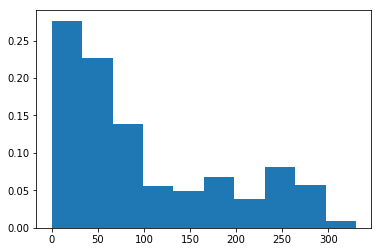

In [22]:
# maximum number of Links in our network
L_max = n_nodes*(n_nodes-1)/2
print('L_max =', L_max)

# number of link in our network
L = np.count_nonzero(adjacency)
print('L =',L)

# sparisty
sparsity = (L_max-L)/L_max
print('Sparsity =', sparsity)

# Create the binary version of adjacency matrix as our adjacency is weighted
adj_binary = adjacency.astype(bool).astype(int)
degree =  np.sum(adj_binary, axis=0)

#Histogram of degree distribution
weights = np.ones_like(degree) / float(n_nodes)
plt.hist(degree, weights=weights);

In [25]:
G_adjacency = nx.from_numpy_array(adjacency)
G_BC = max(nx.connected_component_subgraphs(G_adjacency), key=len)

try:
    BC_nparray = np.load('BC.npy')

except FileNotFoundError: 
   
    BC_nparray = nx.to_numpy_array(G_BC)
    #Save biggest component into a NPY array
    np.save("BC.npy", BC_nparray)
    
print('N° of connected components =',nx.number_connected_components(G_adjacency))
print('Clustering coefficient of our Biggest Component =' ,nx.average_clustering(G_BC))

N° of connected components = 78
Clustering coefficient of our Biggest Component = 0.5605044574460251


In [ ]:
##NOT FINISHED (PARTIE DE BENOIT AVANT)
##BC = np.load('biggest_component.npy')


# Labels are 1 if the movie contains 'Comedy' in its genres and 0 if it does not
nodes_bc = np.load('nodes_bc.npy')
labels = np.load('labels.npy')[nodes_bc]
labels = np.array([label if label == 1 else -1 for label in labels])
labels = labels.astype(float)

n_nodes = len(BC)

degree_biggest_component= np.sum(BC_nparray, axis=0)

#Gradient calculation:

# Let us compute the gradient
N = BC.shape[0]  # number of nodes
E = np.sum(BC>0)  # number of edges (non-zero entries of A)
gradient = np.zeros((E, N))
eij = 0  # edge index

for i in range(N):
    for j in range(N):
        wij = BC[i, j]
        if wij > 0:
            gradient[eij,i] = math.sqrt(wij)/math.sqrt(2*degree_biggest_component[i])
            gradient[eij,j] = -math.sqrt(wij)/math.sqrt(2*degree_biggest_component[j])
            eij = eij + 1  # increment the edge index
            
laplacian = (gradient.T@gradient) #Laplacian Normalisé calculé avec le gradient.

sparse_gradient = sparse.csr_matrix(gradient)
sparse_laplacian = sparse.csr_matrix(laplacian)